# Use Quantile Mapping to Calculate 'current-year' SWE in the UCRB

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import pickle
import scipy.stats as stats
import os.path

### Load and preprocess data:

In [2]:
swe = xr.open_dataset('../data/reanalysis/swe_reanalysis_ucrb.nc')
stations = pickle.load(open('../data/snv_dataframes/snv_temp_precip_cluster_gdf_snvs_quantiles.pkl','rb'))

In [3]:
ucrb = pickle.load(open('../data/misc/ucrb.pkl','rb'))

In [4]:
nearest_station_sc_4326 = xr.open_dataset('../data/calculated_swe/intermediate_ncs/nearest_station_wic_sc.nc')

In [5]:
nearest_station_sc_4326 = nearest_station_sc_4326.__xarray_dataarray_variable__

In [6]:
stations_ucrb = stations.clip(ucrb)

In [13]:
stations_ucrb

station_n  reanalysis_n  elevation_m  station_swe  \
station     year                                                      
874_CO_SNTL 1990  -1.158316     -1.363052  3352.800049      0.48260   
            1991   0.836619     -0.920469  3352.800049      0.94234   
            2021   0.241445     -0.812500  3352.800049      0.80518   
            2020  -0.166359     -0.344040  3352.800049      0.71120   
            2019   1.861640      0.944449  3352.800049      1.17856   
...                     ...           ...          ...          ...   
555_WY_SNTL 1995  -0.274240     -0.375197  2359.152100      0.28702   
            1994  -0.554315     -0.556152  2359.152100      0.25654   
            1993  -0.227561      0.618156  2359.152100      0.29210   
            1992  -1.487899     -1.163552  2359.152100      0.15494   
            1991  -0.390938     -0.458715  2359.152100      0.27432   

                  station_swe_mean  reanalysis_swe  deg_days_0C  \
station     year                                                  
874_CO_SNTL 1990          0.749538          0.3130         12.0   
            1991          0.749538          0.4122          2.0   
            2021          0.749538          0.4364          6.0   
            2020          0.749538          0.5414         10.0   
            2019          0.749538          0.8302          2.0   
...                            ...             ...          ...   
555_WY_SNTL 1995          0.316865          0.2436          2.0   
            1994          0.316865          0.2150          2.0   
            1993          0.316865          0.4006          5.0   
            1992          0.316865          0.1190          0.0   
            1991          0.316865          0.2304          0.0   

                  cold_deg_days  cumulative_precip_m  precip_mean  ...  \
station     year                                                   ...   
874_CO_SNTL 1990            0.0             0.250970     0.286080  ...   
            1991            0.0             0.358043     0.286080  ...   
            2021            0.0             0.255747     0.286080  ...   
            2020            0.0             0.299887     0.286080  ...   
            2019            0.0             0.423093     0.286080  ...   
...                         ...                  ...          ...  ...   
555_WY_SNTL 1995            0.0             0.326875     0.305987  ...   
            1994            0.0             0.240545     0.305987  ...   
            1993            0.0             0.334753     0.305987  ...   
            1992            1.0             0.191015     0.305987  ...   
            1991            1.0             0.240227     0.305987  ...   

                  log_station_n  log_reanalysis_n   latitude   longitude  \
station     year                                                           
874_CO_SNTL 1990      -1.143926         -1.648659  37.479221 -106.801697   
            1991       0.826784         -0.911367  37.479221 -106.801697   
            2021       0.363539         -0.758581  37.479221 -106.801697   
            2020      -0.001968         -0.181188  37.479221 -106.801697   
            2019       1.485523          0.963717  37.479221 -106.801697   
...                         ...               ...        ...         ...   
555_WY_SNTL 1995      -0.130477         -0.182563  43.249298 -110.016617   
            1994      -0.464555         -0.423338  43.249298 -110.016617   
            1993      -0.078269          0.776448  43.249298 -110.016617   
            1992      -1.965062         -1.563725  43.249298 -110.016617   
            1991      -0.265149         -0.289968  43.249298 -110.016617   

                                     geometry  cluster  \
station     year                                         
874_CO_SNTL 1990  POINT (-106.80170 37.47922)      0.0   
            1991  POINT (-106.80170 37.47922)      0.0   
            2021  POINT (-106.80170 37

In [7]:
stations_1yr = stations_ucrb[stations_ucrb.index.get_level_values(1) == 1990]
stations_1yr = stations_1yr.reset_index(level=1, drop=True)

In [8]:
stations_1yr['id'] = np.nan

In [9]:
for i in range(len(stations_1yr)):
    stations_1yr.loc[stations_1yr.index[i], 'id'] = i

### Calculate and save station quantiles:

In [26]:
# This uses the unbiased median method (Q8 in Hyndman and Fan 1996). 
# Previously, I populated the 'quantile' column of the stations df using the default 'linear' method (Q7 in Hyndman and Fan 1996)

stations['quantile_q8'] = np.nan

quantiles = np.linspace(0,1,100)

for site in stations.index.get_level_values(0).unique():
    station_ordered = stats.mstats.mquantiles(stations[stations.index.get_level_values(0) == site]['station_swe'].values, quantiles, alphap=(1/3), betap=(1/3))
    q_station = np.interp(stations[stations.index.get_level_values(0) == site]['station_swe'].values, station_ordered, quantiles)
    stations.loc[(stations.index.get_level_values(0) == site), 'quantile_q8'] = q_station

In [18]:
stations

station_n  reanalysis_n  elevation_m  station_swe  \
station     year                                                      
301_CA_SNTL 1990  -0.492262     -0.194751  1886.712036     0.193040   
            1991  -0.806681      0.193222  1886.712036     0.142240   
            1992  -1.639892     -1.097426  1886.712036     0.007620   
            1993   0.938344     -0.578276  1886.712036     0.424180   
            1994  -0.335053     -0.422643  1886.712036     0.218440   
...                     ...           ...          ...          ...   
BLD         2017   0.619445      1.160298  2194.560000     1.033272   
            2018  -0.806206     -1.171988  2194.560000     0.371856   
            2019   0.501188      1.293572  2194.560000     0.978408   
            2020  -0.615681     -0.258835  2194.560000     0.460248   
            2021  -0.418586     -0.760679  2194.560000     0.551688   

                  station_swe_mean  reanalysis_swe  deg_days_0C  \
station     year                                                  
301_CA_SNTL 1990          0.272574          0.1718         57.0   
            1991          0.272574          0.2416         47.0   
            1992          0.272574          0.0094         64.0   
            1993          0.272574          0.1028         42.0   
            1994          0.272574          0.1308         48.0   
...                            ...             ...          ...   
BLD         2017          0.745887          1.1946         54.0   
            2018          0.745887          0.1796         82.0   
            2019          0.745887          1.2526         59.0   
            2020          0.745887          0.5770         68.0   
            2021          0.745887          0.3586         55.0   

                  cold_deg_days  cumulative_precip_m  precip_mean  ...  \
station     year                                                   ...   
301_CA_SNTL 1990            0.0             0.223842     0.332045  ...   
            1991            0.0             0.237158     0.332045  ...   
            1992            0.0             0.197154     0.332045  ...   
            1993            0.0             0.449491     0.332045  ...   
            1994            0.0             0.223718     0.332045  ...   
...                         ...                  ...          ...  ...   
BLD         2017            0.0             1.722192     0.846466  ...   
            2018            0.0             0.807857     0.846466  ...   
            2019            0.0             1.363057     0.846466  ...   
            2020            0.0             0.671916     0.846466  ...   
            2021            0.0             0.578816     0.846466  ...   

                  log_station_n  log_reanalysis_n   latitude   longitude  \
station     year                                                           
301_CA_SNTL 1990            NaN               NaN  41.235828 -120.791924   
            1991            NaN               NaN  41.235828 -120.791924   
            1992            NaN               NaN  41.235828 -120.791924   
            1993            NaN               NaN  41.235828 -120.791924   
            1994            NaN               NaN  41.235828 -120.791924   
...                         ...               ...        ...         ...   
BLD         2017       0.712421               NaN  38.451256 -120.034882   
            2018      -0.648226               NaN  38.451256 -120.034882   
            2019       0.639782               NaN  38.451256 -120.034882   
            2020      -0.364297               NaN  38.451256 -120.034882   
            2021      -0.123027               NaN  38.451256 -120.034882   

                                     geometry  cluster  \
station     year                                         
301_CA_SNTL 1990  POINT (-120.79192 41.23583)      3.0   
            1991  POINT (-120.79192 41.23583)      3.0   
            1992  POINT (-120.79192 41

In [27]:
# Save as a new dataframe with the quantile values included:
# stations.to_pickle('../data/snv_dataframes/snv_temp_precip_cluster_gdf_snvs_quantiles.pkl')

### Inspect one site's CDFs using the different empirical quantile calculation methods from Hyndman and Fan 1996:

In [21]:
site = '301_CA_SNTL'

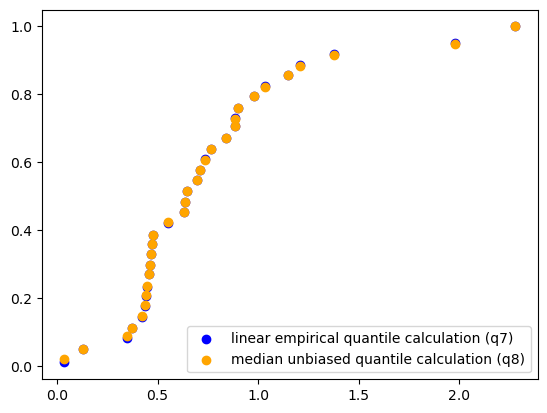

In [32]:
fig, ax = plt.subplots()
plt.scatter(stations.loc[(stations.index.get_level_values(0) == site), 'station_swe'],stations.loc[(stations.index.get_level_values(0) == site), 'quantile'], color='blue', label='linear empirical quantile calculation (q7)')
plt.scatter(stations.loc[(stations.index.get_level_values(0) == site), 'station_swe'],stations.loc[(stations.index.get_level_values(0) == site), 'quantile_q8'], color='orange', label='median unbiased quantile calculation (q8)')
plt.legend()

### Calculate the mean quantile within each cluster:

In [15]:
mean_quantile = xr.full_like(swe.SWE_Post, np.nan)

In [16]:
clusters_reanalysis = xr.open_dataset('../data/swe_reanalysis_5clusters.nc')
clusters_reanalysis = clusters_reanalysis.__xarray_dataarray_variable__
clusters_reanalysis  = clusters_reanalysis.rio.write_crs('epsg:4326')
clusters_ucrb = clusters_reanalysis.rio.clip(ucrb.geometry)
clusters_reanalysis_match = clusters_ucrb.rio.reproject_match(swe)

In [17]:
stations_ucrb = stations.clip(ucrb)

In [19]:
for year in np.arange(0,32):
    for cluster in np.arange(0,4):
        mean_quantile[year] = mean_quantile[year].where(clusters_reanalysis_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['sampled_reanalysis_cluster']==cluster)]['quantile_q8'].mean())

### Get the quantile of the nearest within-cluster snotel:

## Need to double check the intermediate files to see which cluster definitions they use!

In [26]:
if os.path.isfile('../data/calculated_swe/nearest_station_quantile_sc_checkcluster.nc'):
    nearest_station_quantile_sc = xr.open_dataarray('../data/calculated_swe/nearest_station_quantile_sc_checkcluster.nc')
else: 
    nearest_station_quantile_sc = xr.full_like(swe.SWE_Post, np.nan)
    # populate this dataframe with that snotel's swe data:
    site_ids = list(np.unique(nearest_station_sc_4326.data))
    site_ids_nan = site_ids[0:-1]
    
    for i in site_ids_nan:
        for year in range(0,32):
            nearest_station_quantile_sc[year] = nearest_station_quantile_sc[year].where((nearest_station_sc_4326 != i), stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['quantile_q8'].values[0])

In [25]:
# # Make empty data array (with time dimension) to populate with nearest snotel's swe data:
# nearest_station_quantile_sc = xr.full_like(swe.SWE_Post, np.nan)

# # populate this dataframe with that snotel's swe data:
# site_ids = list(np.unique(nearest_station_sc_4326.data))
# site_ids_nan = site_ids[0:-1]

# for i in site_ids_nan:
#     for year in range(0,32):
#         nearest_station_quantile_sc[year] = nearest_station_quantile_sc[year].where((nearest_station_sc_4326 != i), stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['quantile'].values[0])

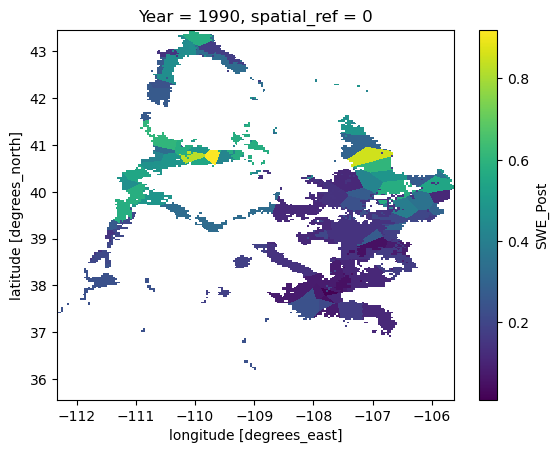

In [27]:
nearest_station_quantile_sc[0].plot()

In [28]:
# nearest_station_quantile_sc.to_netcdf('../data/calculated_swe/nearest_station_quantile_sc.nc')

### Get the quantile of the nearest snotel, regardless of cluster:

In [68]:
nearest_station = xr.open_dataset('../data/calculated_swe/intermediate_ncs/nearest_station.nc')

In [73]:
file_path = '../data/calculated_swe/intermediate_ncs/nearest_station_quantile.nc'

if os.path.isfile(file_path):
    nearest_station_quantile = xr.open_dataarray(file_path)
else: 
    nearest_station = xr.open_dataset('../data/calculated_swe/intermediate_ncs/nearest_station.nc')
    nearest_station = nearest_station.__xarray_dataarray_variable__
    nearest_station_quantile = xr.full_like(swe.SWE_Post, np.nan)
    # populate this dataframe with that snotel's quantile data:
    site_ids = list(np.unique(nearest_station.data))
    site_ids_nan = site_ids[0:-1]
    
    for i in site_ids_nan:
        for year in range(0,32):
            nearest_station_quantile[year] = nearest_station_quantile[year].where((nearest_station != i), stations_ucrb[(stations_ucrb.index.get_level_values(1)==(year + 1990)) & (stations_ucrb.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['quantile_q8'].values[0])
    nearest_station_quantile.to_netcdf('../data/calculated_swe/intermediate_ncs/nearest_station_quantile.nc')    

## Use Xarray interp (thanks Steven!):

### Make a CDF at each gridcell

#### Using the Linear method (old)

In [114]:
# # Calculate CDF using Linear method (Q7)

# quantiles = np.linspace(0,1,100)

# for year in np.arange(1990, 2022):

#     quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year}.nc'
    
#     if os.path.isfile(quantile_fn):
#         continue
#     else:
#         sr_quantiles_yr = swe.SWE_Post.where((swe.SWE_Post['Year'] != year), drop=True).quantile(quantiles, dim='Year', method='linear')
#         sr_quantiles_yr.to_netcdf(quantile_fn)

#### Using the unbiased median method (current):

In [34]:
# Calculate CDF using median unbiased method (Q8)

quantiles = np.linspace(0,1,100)

for year in np.arange(1990, 2022):

    quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year}_q8.nc'
    
    if os.path.isfile(quantile_fn):
        continue
    else:
        sr_quantiles_yr = swe.SWE_Post.where((swe.SWE_Post['Year'] != year), drop=True).quantile(quantiles, dim='Year', method='median_unbiased')
        sr_quantiles_yr.to_netcdf(quantile_fn)

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunc

### Repeat the above, making one file that contains all years of data (for clustering):

In [11]:
# Calculate CDF using median unbiased method (Q8)

quantiles = np.linspace(0,1,100)

quantile_fn = '../data/quantile_ncs/sr_quantiles_allyears_q8.nc'

sr_quantiles_all = swe.SWE_Post.quantile(quantiles, dim='Year', method='median_unbiased')
sr_quantiles_all.to_netcdf(quantile_fn)

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


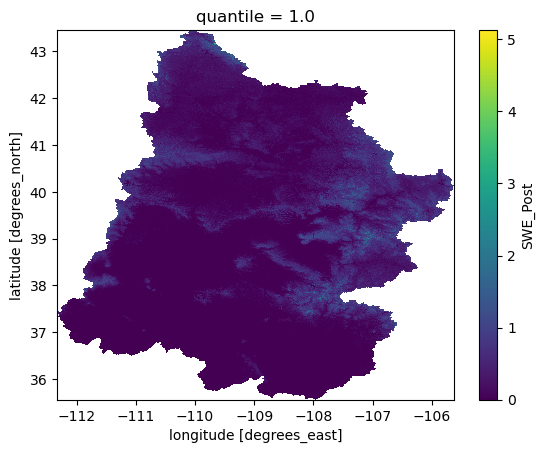

In [16]:
sr_quantiles_all[99].plot()

### Quantile map each year's SWE using the mean quantile in each cluster:

In [48]:
file_path = '../data/calculated_swe/quantiles/calculated_swe_quantile_mean_wic_sc_newmethod_q8.nc'

if os.path.isfile(file_path):
    calculated_swe_quantiles_xr_q8 = xr.open_dataarray(file_path)
else:
    calculated_swe_quantiles_xr_q8 = xr.full_like(swe.SWE_Post, np.nan)
    for year in np.arange(0,32):
        quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year+1990}_q8.nc'
        sr_quantiles_yr = xr.open_dataarray(quantile_fn)
        calculated_swe_quantiles_xr_q8[year] = sr_quantiles_yr.interp(quantile=mean_quantile[year], method='linear')
        calculated_swe_quantiles_xr_q8.to_netcdf(file_path)

In [40]:
# calculated_swe_quantiles_xr_q8 = xr.full_like(swe.SWE_Post, np.nan)

# for year in np.arange(0,32):
#     quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year+1990}_q8.nc'
#     sr_quantiles_yr = xr.open_dataarray(quantile_fn)
#     calculated_swe_quantiles_xr_q8[year] = sr_quantiles_yr.interp(quantile=mean_quantile[year], method='linear')

# calculated_swe_quantiles_xr_q8.to_netcdf('../data/calculated_swe/quantiles/calculated_swe_quantile_mean_wic_sc_newmethod_q8.nc')

#### Calculated the difference between SWE Reanalysis and Snotel quantiles:

In [124]:
quantiles_dif = calculated_swe_quantiles_xr - swe_reanalysis_quantile_cluster_mean

### Quantile map each year's SWE using the nearest within-cluster station:

In [50]:
file_path = '../data/calculated_swe/quantiles/calculated_swe_quantile_newmethod_q8_nearest_wic_sc.nc'

if os.path.isfile(file_path):
    calculated_swe_quantiles_xr_q8_nearest_wic = xr.open_dataarray(file_path)
else:
    calculated_swe_quantiles_xr_q8_nearest_wic = xr.full_like(swe.SWE_Post, np.nan)

    for year in np.arange(0,32):
        quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year+1990}_q8.nc'
        sr_quantiles_yr = xr.open_dataarray(quantile_fn)
        calculated_swe_quantiles_xr_q8_nearest_wic[year] = sr_quantiles_yr.interp(quantile=nearest_station_quantile_sc[year], method='linear')
    calculated_swe_quantiles_xr_q8_nearest_wic.to_netcdf(file_path)    

### Quantile map each year's SWE using the nearest station:

In [10]:
nearest_station_quantile = xr.open_dataarray('../data/calculated_swe/intermediate_ncs/nearest_station_quantile.nc')

In [12]:
file_path = '../data/calculated_swe/quantiles/calculated_swe_quantile_newmethod_q8_nearest.nc'

if os.path.isfile(file_path):
    calculated_swe_quantiles_xr_q8_nearest = xr.open_dataarray(file_path)
else:
    calculated_swe_quantiles_xr_q8_nearest = xr.full_like(swe.SWE_Post, np.nan)

    for year in np.arange(0,32):
        quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year+1990}_q8.nc'
        sr_quantiles_yr = xr.open_dataarray(quantile_fn)
        calculated_swe_quantiles_xr_q8_nearest[year] = sr_quantiles_yr.interp(quantile=nearest_station_quantile[year], method='linear')
    calculated_swe_quantiles_xr_q8_nearest.to_netcdf(file_path)    

In [44]:
# calculated_swe_quantiles_xr_q8_nearest_wic = xr.full_like(swe.SWE_Post, np.nan)

# for year in np.arange(0,32):
#     quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year+1990}_q8.nc'
#     sr_quantiles_yr = xr.open_dataarray(quantile_fn)
#     calculated_swe_quantiles_xr_q8_nearest_wic[year] = sr_quantiles_yr.interp(quantile=nearest_station_quantile_sc[year], method='linear')

# calculated_swe_quantiles_xr_q8_nearest_wic.to_netcdf('../data/calculated_swe/quantiles/calculated_swe_quantile_mean_wic_sc_newmethod_q8_nearest_wic_sc.nc')

### Quantile map each year's SWE using the mean quantile from the entire UCRB:

In [57]:
file_path = '../data/calculated_swe/quantiles/calculated_swe_quantile_mean_all_q8.nc'

if os.path.isfile(file_path):
    calculated_swe_quantiles_xr_q8_mean_all = xr.open_dataarray(file_path)
else:
    calculated_swe_quantiles_xr_q8_mean_all = xr.full_like(swe.SWE_Post, np.nan)
    for year in np.arange(0,32):
        quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year+1990}_q8.nc'
        sr_quantiles_yr = xr.open_dataarray(quantile_fn)
        calculated_swe_quantiles_xr_q8_mean_all[year] = sr_quantiles_yr.interp(quantile=stations_ucrb[stations_ucrb.index.get_level_values(1)==(year + 1990)]['quantile_q8'].values.mean(), method='linear')
    calculated_swe_quantiles_xr_q8_mean_all.to_netcdf(file_path)  

In [74]:
old_method_mean_wic = xr.open_dataset('../data/calculated_swe/quantiles/calculated_swe_quantile_mean_wic_sc.nc')

### Compare the grid cell iteration method to the xarray interp method:


In [76]:
method_dif = calculated_swe_quantiles_xr_q8 - old_method_mean_wic

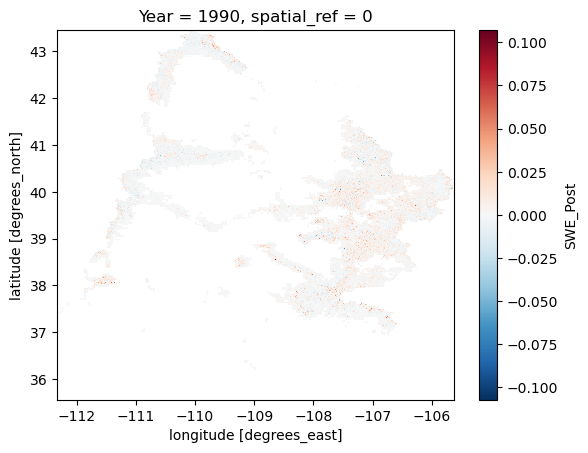

In [78]:
method_dif.SWE_Post[0].plot()

### Attempt to use xclim package to do quantile mapping:

In [20]:
from xclim import sdba

#### preprosses data by renaming attributes/variables and formatting time axis:

In [285]:
nearest_station_swe_sc = nearest_station_swe_sc.rename(Year="time")

In [286]:
swe = swe.rename(Year="time")

In [25]:
nearest_station_swe_sc

<xarray.DataArray 'SWE_Post' (time: 32, y: 1776, x: 1508)> Size: 343MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x            (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * time         (time) int64 256B 1990 1991 1992 1993 ... 2018 2019 2020 2021
    spatial_ref  int64 8B ...
Attributes:
    Units:    meters

In [28]:
swe.SWE_Post

<xarray.DataArray 'SWE_Post' (time: 32, y: 1776, x: 1508)> Size: 343MB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x            (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * time         (time) int64 256B 1990 1991 1992 1993 ... 2018 2019 2020 2021
    spatial_ref  int64 8B ...
Attributes:
    Units:    meters

In [36]:
example_swe.SWE_Post

<xarray.DataArray 'SWE_Post' (Longitude: 5175, Latitude: 4050)> Size: 84MB
[20958750 values with dtype=float32]
Coordinates:
  * Latitude   (Latitude) float64 32kB 31.0 31.01 31.01 ... 48.99 48.99 49.0
  * Longitude  (Longitude) float64 41kB -125.0 -125.0 -125.0 ... -102.0 -102.0
Attributes:
    Units:    meters

In [287]:
nearest_station_swe_sc.attrs['units'] = nearest_station_swe_sc.attrs.pop('Units')

In [288]:
swe.SWE_Post.attrs['units'] = swe.SWE_Post.attrs.pop('Units')

In [289]:
nearest_station_swe_sc['time'] = xr.cftime_range(start="1990", periods=32, freq="YS-APR", calendar="noleap")

In [290]:
swe['time'] = xr.cftime_range(start="1990", periods=32, freq="YS-APR", calendar="noleap")

In [ ]:
#nearest_station_swe_sc = nearest_station_swe_sc.assign_attrs(dt = '')

In [48]:
nearest_station_swe_sc = nearest_station_swe_sc.rio.reproject_match(swe)

In [292]:
nearest_station_swe_sc = nearest_station_swe_sc.rename(x="Longitude", y='Latitude')

In [293]:
swe = swe.rename(x="Longitude", y='Latitude')

#### Train the quantile mapping:

In [297]:
QM = sdba.EmpiricalQuantileMapping.train(
    nearest_station_swe_sc, swe.SWE_Post, nquantiles=30, group="time", kind="+"
)

In [44]:
QM

EmpiricalQuantileMapping(group=Grouper(name='time'), kind='+')

#### Calculate SWE using quantile mapping?

In [298]:
scen3 = QM.adjust(swe.SWE_Post, interp="linear")

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/xclim/sdba/utils.py:318: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [295]:
scen2 = QM.adjust(swe.SWE_Post, interp="linear")

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/xclim/sdba/utils.py:318: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


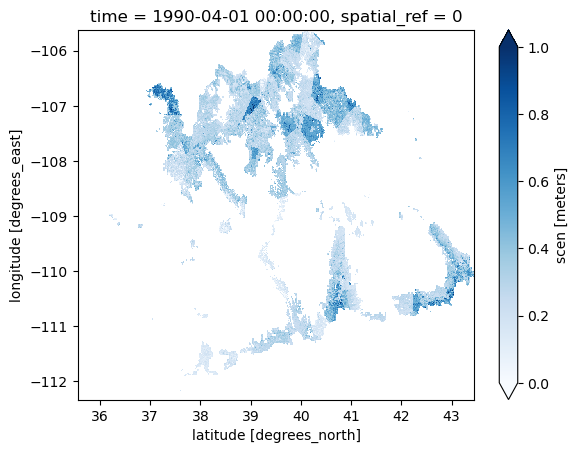

In [299]:
scen3.sel(time='1990-04-01').plot(cmap='Blues',vmin=0, vmax=1)

In [301]:
dif_quant_xclim = scen3 - swe.SWE_Post

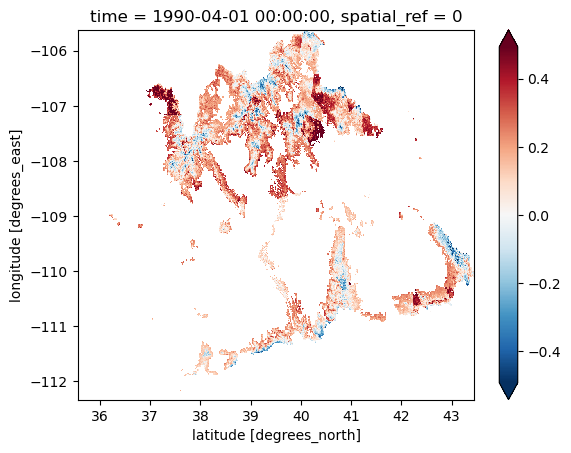

In [303]:
dif_quant_xclim.sel(time='1990-04-01').plot(robust=True)

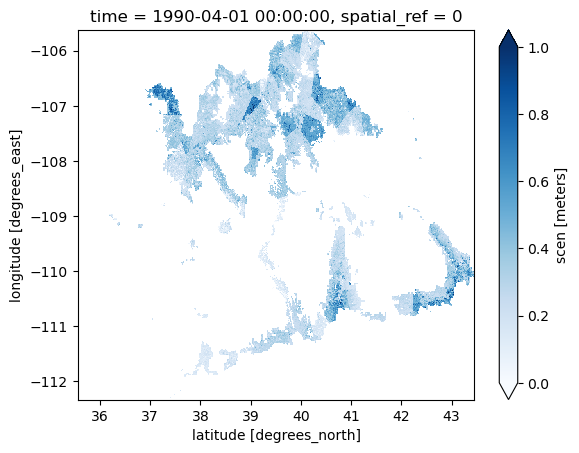

In [296]:
scen2.sel(time='1990-04-01').plot(cmap='Blues',vmin=0, vmax=1)

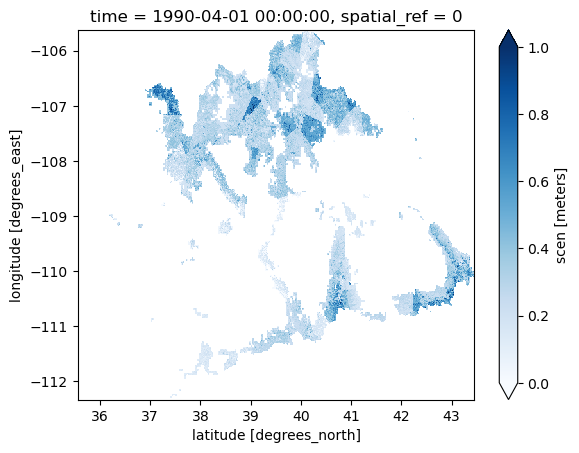

In [66]:
scen.sel(time='1990-04-01').plot(cmap='Blues',vmin=0, vmax=1)

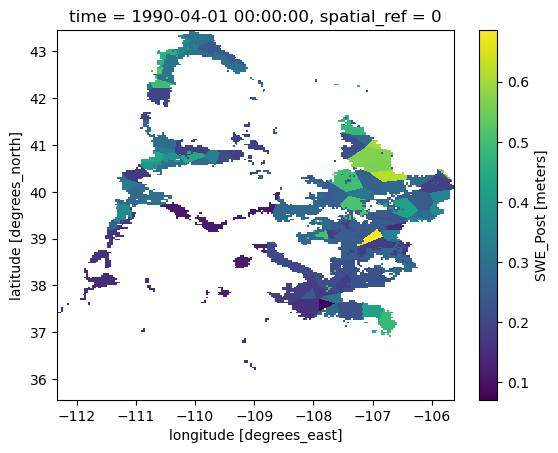

In [57]:
nearest_station_swe_sc.sel(time='1990-04-01').plot()

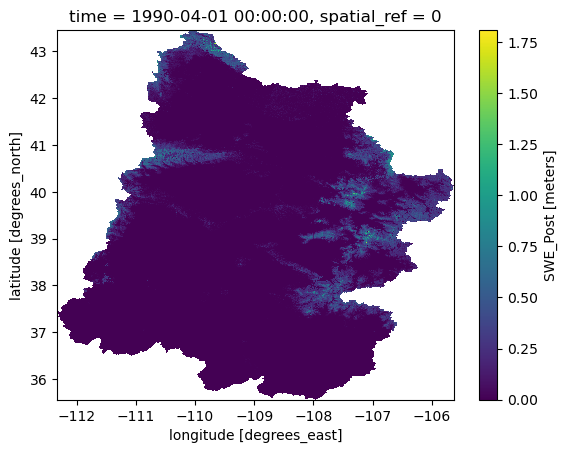

In [56]:
swe.SWE_Post[0].plot()

In [ ]:
from xclim import sdba

QM = sdba.EmpiricalQuantileMapping.train(
    ref, hist, nquantiles=15, group="time", kind="+"
)
scen = QM.adjust(sim, extrapolation="constant", interp="nearest")

### Try my own method for quantile mapping:

In [72]:
swe_flat = swe.SWE_Post.stack(point=('x', 'y'))
nearest_station_flat = nearest_station_swe_sc.stack(point=('x', 'y'))

In [76]:
swe_quantiles = swe.SWE_Post.quantile(q=np.linspace(0, 1, 15), dim='Year', method = 'weibull')

In [94]:
station_quantiles = nearest_station_swe_sc.quantile(q=np.linspace(0, 1, 15), dim='Year', method = 'weibull')

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [77]:
swe_quantiles

<xarray.DataArray 'SWE_Post' (quantile: 15, y: 1776, x: 1508)> Size: 161MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 120B 0.0 0.07143 0.1429 ... 0.8571 0.9286 1.0

### Populate the nearest within-cluster station's SWE to a data array:

In [15]:
# Make empty data array (with time dimension) to populate with nearest snotel's swe data:
nearest_station_swe_sc = xr.full_like(swe.SWE_Post, np.nan)

In [16]:
# populate this dataframe with that snotel's swe data:
site_ids = list(np.unique(nearest_station_sc_4326.data))
site_ids_nan = site_ids[0:-1]

for i in site_ids_nan:
    for year in range(0,32):
        nearest_station_swe_sc[year] = nearest_station_swe_sc[year].where((nearest_station_sc_4326 != i), stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['station_swe'].values[0])

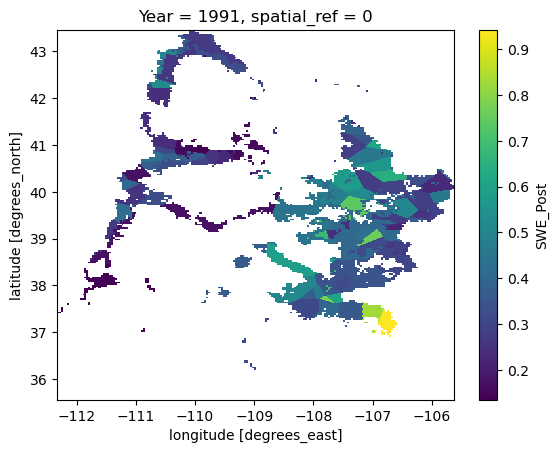

In [19]:
nearest_station_swe_sc[1].plot()

### Test methods on one grid cell:

In [86]:
swe.SWE_Post[0].argmax(dim=['x','y'])

{'x': <xarray.DataArray 'SWE_Post' ()> Size: 8B
 array(598)
 Coordinates:
     Year         int64 8B 1990
     spatial_ref  int64 8B ...,
 'y': <xarray.DataArray 'SWE_Post' ()> Size: 8B
 array(1712)
 Coordinates:
     Year         int64 8B 1990
     spatial_ref  int64 8B ...}

In [88]:
max_cell = swe.SWE_Post.isel(x=598, y=1712)

In [89]:
max_cell

<xarray.DataArray 'SWE_Post' (Year: 32)> Size: 128B
array([1.81  , 2.0352, 2.1148, 1.2452, 1.5628, 1.7678, 2.6656, 2.612 , 3.0714,
       3.8288, 3.035 , 1.8424, 1.8206, 2.184 , 1.8218, 2.5552, 3.192 , 2.6204,
       2.3626, 2.4838, 3.4684, 3.1068, 3.7142, 2.286 , 3.1072, 3.4928, 3.6354,
       3.495 , 3.2738, 3.4272, 3.1882, 2.7756], dtype=float32)
Coordinates:
    y            float64 8B 43.17
    x            float64 8B -109.7
  * Year         (Year) int64 256B 1990 1991 1992 1993 ... 2018 2019 2020 2021
    spatial_ref  int64 8B ...
Attributes:
    Units:    meters

In [91]:
nearest_station_swe_sc.isel(x=598, y=1712, Year=15)

<xarray.DataArray 'SWE_Post' ()> Size: 4B
array(0.31242, dtype=float32)
Coordinates:
    y            float64 8B 43.17
    x            float64 8B -109.7
    Year         int64 8B 2005
    spatial_ref  int64 8B ...
Attributes:
    Units:    meters

In [93]:
swe_quantiles.isel(x=598, y=1712)

<xarray.DataArray 'SWE_Post' (quantile: 15)> Size: 60B
array([1.2452   , 1.6360143, 1.8175714, 1.8561714, 2.144457 , 2.3461857,
       2.5633144, 2.6430001, 2.997943 , 3.1068857, 3.1903713, 3.4162428,
       3.4934285, 3.686057 , 3.8288   ], dtype=float32)
Coordinates:
    y         float64 8B 43.17
    x         float64 8B -109.7
  * quantile  (quantile) float64 120B 0.0 0.07143 0.1429 ... 0.8571 0.9286 1.0

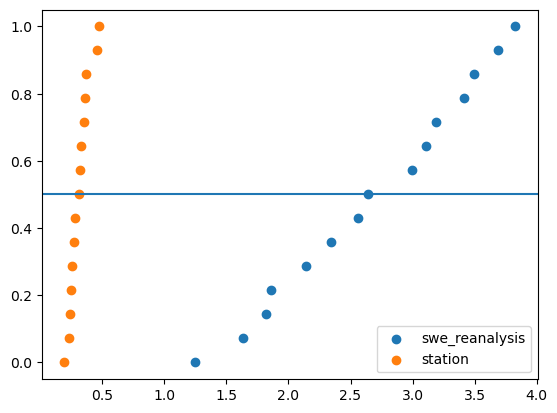

In [113]:
fig, ax = plt.subplots()
plt.scatter(swe_quantiles.isel(x=598, y=1712).values, quantiles, label='swe_reanalysis')
plt.scatter(station_quantiles.isel(x=598, y=1712).values, quantiles, label='station')
plt.axhline(y=0.5)
plt.legend()

### Use steven's code:

#### Get the reanalysis gridcell closest to the Butte site:

In [149]:
x1 = stations[(stations.index.get_level_values(0) == '380_CO_SNTL') & (stations.index.get_level_values(1) == 1990)].geometry.x.values
y1 = stations[(stations.index.get_level_values(0) == '380_CO_SNTL') & (stations.index.get_level_values(1) == 1990)].geometry.y.values

In [176]:
x1

array([-106.95300293])

In [180]:
swe.SWE_Post.isel(x=idx[0], y=idy[0]).x.values

array(-106.95330048)

In [177]:
y1

array([38.89432907])

In [181]:
swe.SWE_Post.isel(x=idx[0], y=idy[0]).y.values

array(38.89556122)

In [152]:
dist_y = np.sqrt((swe['y'].values - y1)**2) 
dist_x = np.sqrt((swe['x'].values - x1)**2)

In [154]:
idy = np.argwhere(dist_y == np.min(dist_y))[0]
idx = np.argwhere(dist_x == np.min(dist_x))[0]

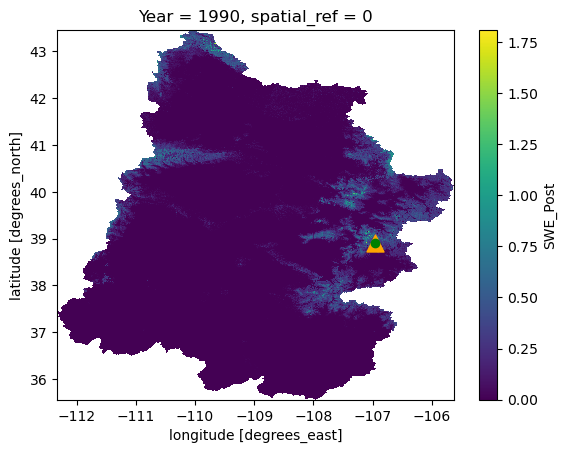

In [183]:
fig, ax = plt.subplots()
swe.SWE_Post[0].plot(ax=ax)
plt.scatter(x1,y1,marker = '^',s=150,color='orange')
plt.scatter(swe.x[idx[0]],swe.y[idy[0]],color='green')

#### Perform the quantile mapping:

In [171]:
quantiles = np.linspace(0,1,100)

# This is our empirical cdf of the Slide Canyon data, which also includes values down to 0 and up to 1.
stations_ordered = stats.mstats.mquantiles(nearest_station_swe_sc.isel(x=idx[0], y=idy[0]).values, quantiles)

# This is our empirical cdf of the Blue Canyon data, which also includes values down to 0 and up to 1.
reanalysis_ordered = stats.mstats.mquantiles(swe.SWE_Post.isel(x=idx[0], y=idy[0]).values, quantiles)

In [172]:
# Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
f_stations = interp1d(stations_ordered, quantiles)
# Create our interpolation function for looking up SWE at Blue Canyon given a quantile
g_reanalysis = interp1d(quantiles, reanalysis_ordered)

# Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
reanalysis_predicted = g_reanalysis( f_stations(nearest_station_swe_sc.isel(x=idx[0], y=idy[0])) )


In [173]:
reanalysis_predicted

array([0.25237816, 0.40303493, 0.3425007 , 0.69019997, 0.36162511,
       0.59613898, 0.62059594, 0.58553092, 0.39745142, 0.2957325 ,
       0.40692075, 0.3070957 , 0.29163279, 0.4579008 , 0.33328391,
       0.57185185, 0.46202491, 0.31976404, 0.67051094, 0.48772505,
       0.38668004, 0.53271482, 0.1408    , 0.28250221, 0.46810808,
       0.31976404, 0.4399414 , 0.62059594, 0.28250221, 0.58553092,
       0.45990249, 0.31976404])

NameError: name 'stations_ordered' is not defined

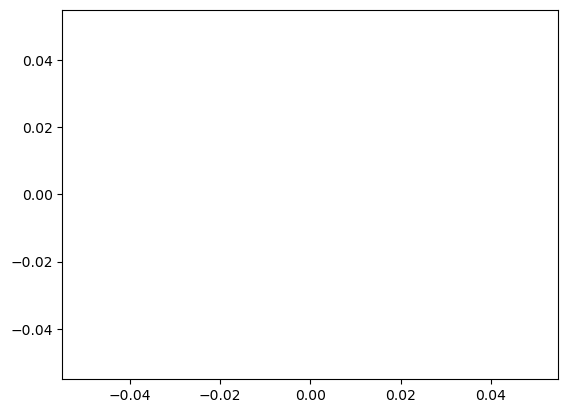

In [129]:
fig, ax = plt.subplots()
plt.scatter(reanalysis_ordered, quantiles, label='swe_reanalysis')
plt.scatter(stations_ordered, quantiles, label='station')
plt.axhline(y=0.5)
plt.xlabel('SWE (m)')
plt.ylabel('Probability')
plt.legend()

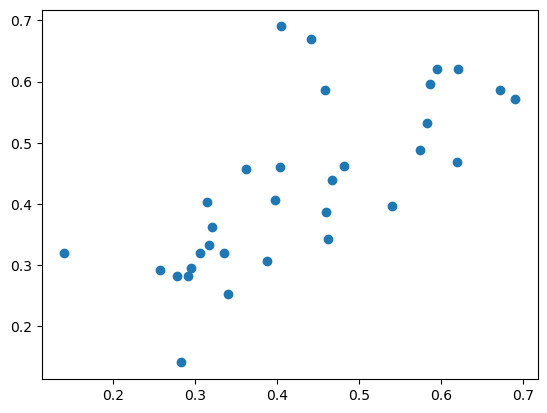

In [175]:
plt.scatter(swe.SWE_Post.isel(x=idx[0], y=idy[0]).values, reanalysis_predicted)

### Scale up the quantile mapping:

In [49]:
3/100

0.03

In [50]:
huc10 = gpd.read_file('../data/huc10_100_snow.geojson')

In [51]:
huc10['huc2'] = huc10['huc2'].astype('int')

In [52]:
huc10 = huc10[huc10['huc2']==14]

In [53]:
east_river = huc10[huc10['name']=='East River']

In [54]:
east_river = east_river.dissolve(by='huc10', aggfunc='sum')

<Axes: >

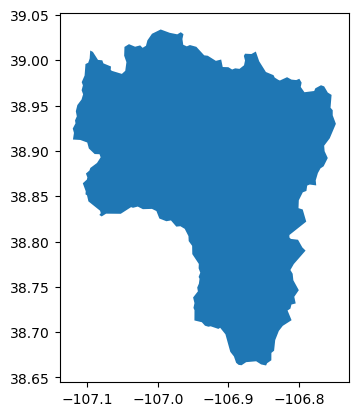

In [208]:
east_river.plot()

In [55]:
mean_quantile_er = mean_quantile.rio.clip(east_river.geometry)

In [56]:
swe_er = swe.rio.clip(east_river.geometry)

In [211]:
nearest_station_swe_sc_huc10 = nearest_station_swe_sc.rio.clip(east_river.geometry)

#### Perform the quantile mapping:

In [214]:
nearest_station_swe_sc_huc10.values.shape

(32, 84, 84)

In [216]:
nearest_station_swe_sc.isel(x=idx[0], y=idy[0]).values.shape

(32,)

In [224]:
def quant(ds, quantiles_to_compute, dim):

    # note: apply always moves core dimensions to the end

    return xr.apply_ufunc(

        stats.mstats.mquantiles, [ds.values, quantiles_to_compute], input_core_dims=[[dim]], vectorize=True

    )

In [225]:
stations_ordered = quant(nearest_station_swe_sc_huc10, quantiles, 'Year')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### Loop over each grid cell:

In [226]:
quantiles = np.linspace(0,1,100)

In [227]:
range(len(swe.x))

range(0, 1508)

In [228]:
swe_reanalysis_quantile_predictions = xr.full_like(swe_huc10, np.nan)

In [279]:
swe_reanalysis_quantile_predictions_ucrb = xr.full_like(swe, np.nan)

In [260]:
np.arange(0,32)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [261]:
swe_reanalysis_quantile_predictions

<xarray.Dataset> Size: 905kB
Dimensions:      (Year: 32, y: 84, x: 84)
Coordinates:
  * y            (y) float64 672B 38.66 38.67 38.67 38.68 ... 39.02 39.03 39.03
  * x            (x) float64 672B -107.1 -107.1 -107.1 ... -106.8 -106.8 -106.7
  * Year         (Year) int64 256B 1990 1991 1992 1993 ... 2018 2019 2020 2021
    spatial_ref  int64 8B 0
Data variables:
    SWE_Post     (Year, y, x) float32 903kB nan nan nan nan ... nan nan nan nan

In [271]:
stations_ordered

array([0.53086001, 0.53086001, 0.53263031, 0.55104146, 0.56945261,
       0.58786377, 0.60110255, 0.61391031, 0.62671807, 0.63292183,
       0.63692426, 0.64092669, 0.64262003, 0.64262003, 0.64262003,
       0.64391311, 0.64711504, 0.65031697, 0.65351891, 0.65672086,
       0.6599228 , 0.66335566, 0.67056002, 0.67776438, 0.68496874,
       0.68792437, 0.69032582, 0.69272727, 0.69626788, 0.70027031,
       0.70427274, 0.7087062 , 0.71350911, 0.71831203, 0.72165251,
       0.72245299, 0.72325348, 0.72405396, 0.72485444, 0.72565492,
       0.72645541, 0.72725589, 0.72805637, 0.72885685, 0.73372134,
       0.73932474, 0.74492813, 0.74676001, 0.74676001, 0.74676001,
       0.74796073, 0.75036218, 0.75276363, 0.75490338, 0.75650434,
       0.75810531, 0.76413973, 0.79455816, 0.82497658, 0.85539501,
       0.87874762, 0.90196169, 0.92517575, 0.95485527, 0.98607418,
       1.01729309, 1.03022399, 1.03262544, 1.03502688, 1.04075343,
       1.05035926, 1.05996508, 1.06703091, 1.06783139, 1.06863

In [272]:
nearest_list = nearest_station_swe_sc_huc10.sel(x=i, y=j, Year=years).values
nearest_list.append(nearest_list.min()-)

array([0.6858 , 0.75946, 0.64262, 1.08204, 0.75438, 1.12776, 1.0668 ,
       1.06934, 0.7239 , 0.62992, 0.72898, 0.74676, 0.70612, 0.72644,
       0.69342, 1.07696, 0.92964, 0.72136, 1.23952, 1.07696, 0.85598,
       1.0287 , 0.58928, 1.03632, 0.53086, 0.64262, 1.25476, 0.65278,
       1.19634, 0.74676, 0.66294], dtype=float32)

In [278]:
swe.x.values[0]

-112.32614135742188

In [277]:
i

-112.32614135742188

In [280]:
for i in swe.x.values:
    for j in swe.y.values:
        
        stations_ordered = stats.mstats.mquantiles(nearest_station_swe_sc.sel(x=i, y=j).values, quantiles)
        reanalysis_ordered = stats.mstats.mquantiles(swe.SWE_Post.sel(x=i, y=j).values, quantiles)

        # Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
        f_stations = interp1d(stations_ordered, quantiles)
        # Create our interpolation function for looking up SWE at Blue Canyon given a quantile
        g_reanalysis = interp1d(quantiles, reanalysis_ordered)
        
        # Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
        reanalysis_predicted = g_reanalysis(f_stations(nearest_station_swe_sc.sel(x=i, y=j)))
        
        # populate the empty dataset at the selected grid cell:
        # swe_reanalysis_quantile_predictions.loc[dict(x=i, y=j)] = reanalysis_predicted
        for year in np.arange(0,32):
            #     swe_reanalysis_quantile_predictions.SWE_Post.isel(x=i, y=j, Year=year).values = reanalysis_predicted[year]
            swe_reanalysis_quantile_predictions_ucrb.SWE_Post.loc[dict(x=i, y=j, Year=(year+1990))] = reanalysis_predicted[year]

In [ ]:
for i in swe.x.values:
    for j in swe.y.values:
        for year in np.arange(0,32):
            stations_ordered = stats.mstats.mquantiles(nearest_station_swe_sc_.sel(x=i, y=j,Year=(year+1990)).values, quantiles)
            reanalysis_ordered = stats.mstats.mquantiles(swe.SWE_Post.sel(x=i, y=j,Year=(year+1990)).).values, quantiles)
    
            # Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
            f_stations = interp1d(stations_ordered, quantiles)
            # Create our interpolation function for looking up SWE at Blue Canyon given a quantile
            g_reanalysis = interp1d(quantiles, reanalysis_ordered)
            
            # Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
            reanalysis_predicted = g_reanalysis(f_stations(nearest_station_swe_sc.sel(x=i, y=j,Year=(year+1990)).)))
        
        # populate the empty dataset at the selected grid cell:
        # swe_reanalysis_quantile_predictions.loc[dict(x=i, y=j)] = reanalysis_predicted
        
            #     swe_reanalysis_quantile_predictions.SWE_Post.isel(x=i, y=j, Year=year).values = reanalysis_predicted[year]
            swe_reanalysis_quantile_predictions.SWE_Post.loc[dict(x=i, y=j, Year=(year+1990))] = reanalysis_predicted[year]

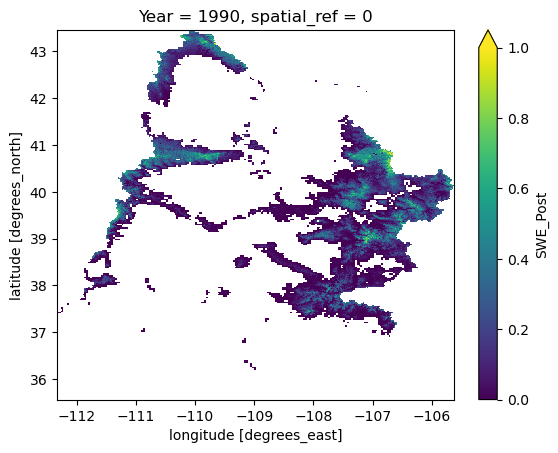

In [282]:
swe_reanalysis_quantile_predictions_ucrb.SWE_Post[0].plot(vmin=0, vmax=1)

In [283]:
swe_reanalysis_quantile_predictions_ucrb.to_netcdf('../data/calculated_swe/calculated_swe_quantile_nearest_wic_sc.nc')

In [315]:
from scipy.interpolate import CubicSpline

In [324]:
i = swe_huc10.where(swe_huc10.mean()>0.1).x.values[0]
j = swe_huc10.where(swe_huc10.mean()>0.1).y.values[0]
quantiles = np.linspace(0,1,100)
year = 0
to_exclude = [year]
years = [element for k, element in enumerate(np.arange(1990,2022)) if k not in to_exclude]
stats.mstats.mquantiles(nearest_station_swe_sc_huc10.sel(x=i, y=j).values, quantiles)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [325]:
swe_huc10.sel(x=i,y=j)

<xarray.Dataset> Size: 408B
Dimensions:      (Year: 32)
Coordinates:
    y            float64 8B 38.66
    x            float64 8B -107.1
  * Year         (Year) int64 256B 1990 1991 1992 1993 ... 2018 2019 2020 2021
    spatial_ref  int64 8B 0
Data variables:
    SWE_Post     (Year) float32 128B nan nan nan nan nan ... nan nan nan nan nan

In [328]:
quantiles = np.linspace(0,1,100)

for i in swe_huc10.x.values:
    for j in swe_huc10.y.values:
        for year in np.arange(0,32):
            
            # exclude the current year to not 'cheat'
            to_exclude = [year]
            years = [element for k, element in enumerate(np.arange(1990,2022)) if k not in to_exclude]
            
            stations_ordered = stats.mstats.mquantiles(nearest_station_swe_sc_huc10.sel(x=i, y=j, Year=years).values, quantiles)
            reanalysis_ordered = stats.mstats.mquantiles(swe_huc10.SWE_Post.sel(x=i, y=j, Year=years).values, quantiles)
    
            # Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
            q_station = np.interp(nearest_station_swe_sc_huc10.sel(x=i, y=j, Year=(year+1990)), stations_ordered, quantiles)
            # Create our interpolation function for looking up SWE at Blue Canyon given a quantile
            #g_reanalysis = np.interp(quantiles, reanalysis_ordered)
            
            # Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
            reanalysis_predicted = np.interp(q_station, quantiles, reanalysis_ordered)
            
            # populate the empty dataset at the selected grid cell:
            # swe_reanalysis_quantile_predictions.loc[dict(x=i, y=j)] = reanalysis_predicted
            
            #     swe_reanalysis_quantile_predictions.SWE_Post.isel(x=i, y=j, Year=year).values = reanalysis_predicted[year]
            swe_reanalysis_quantile_predictions.SWE_Post.loc[dict(x=i, y=j)] = reanalysis_predicted

In [15]:
stations.shape

(14240, 30)

### Calculate SWE using quantile mapping of the mean within-cluster station quantile, looping over grid cells:

In [36]:
swe_reanalysis_quantile_cluster_mean = xr.full_like(swe.SWE_Post, np.nan)

In [38]:
from scipy.interpolate import interp1d

In [40]:
for i in swe.x.values:
    for j in swe.y.values:
        
        #stations_ordered = stats.mstats.mquantiles(nearest_station_swe_sc.sel(x=i, y=j).values, quantiles)
        reanalysis_ordered = stats.mstats.mquantiles(swe.SWE_Post.sel(x=i, y=j).values, quantiles)

        # Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
        #f_stations = interp1d(stations_ordered, quantiles)
        # Create our interpolation function for looking up SWE at Blue Canyon given a quantile
        g_reanalysis = interp1d(quantiles, reanalysis_ordered)
        
        # Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
        reanalysis_predicted = g_reanalysis(mean_quantile.sel(x=i, y=j))
        
        # populate the empty dataset at the selected grid cell:
        # swe_reanalysis_quantile_predictions.loc[dict(x=i, y=j)] = reanalysis_predicted
        for year in np.arange(0,32):
            #     swe_reanalysis_quantile_predictions.SWE_Post.isel(x=i, y=j, Year=year).values = reanalysis_predicted[year]
            swe_reanalysis_quantile_cluster_mean.loc[dict(x=i, y=j, Year=(year+1990))] = reanalysis_predicted[year]

In [42]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/CorrelatedDomains/notebooks


In [43]:
swe_reanalysis_quantile_cluster_mean.to_netcdf('../data/calculated_swe/calculated_swe_quantile_mean_wic_sc.nc')

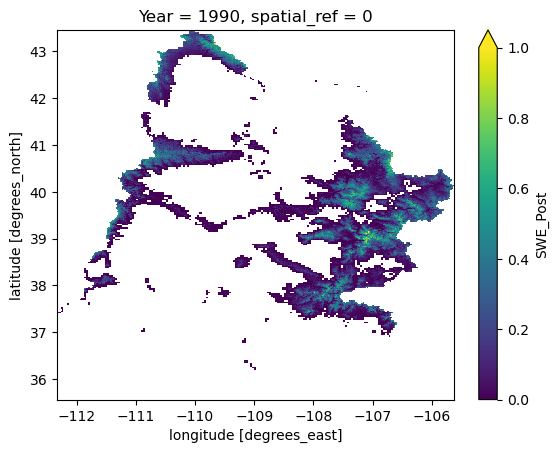

In [45]:
swe_reanalysis_quantile_cluster_mean[0].plot(vmin=0, vmax=1)

In [128]:
sr_quantiles_yr = swe.SWE_Post.quantile(quantiles, dim='Year', method='linear')
sr_quantiles_yr.to_netcdf('..data/quantile_ncs/sr_quantiles_all_year.nc')

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


KeyboardInterrupt: 

In [112]:
# quantiles = np.linspace(0,1,100)

# for year in np.arange(1990, 2022):

#     quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year}_er.nc'
    
#     if os.path.isfile(quantile_fn):
#         continue
#     else:
#         sr_quantiles_er_yr = swe_er.SWE_Post.where((swe_er.SWE_Post['Year'] != year), drop=True).quantile(quantiles, dim='Year', method='linear')
#         sr_quantiles_er_yr.to_netcdf(quantile_fn)

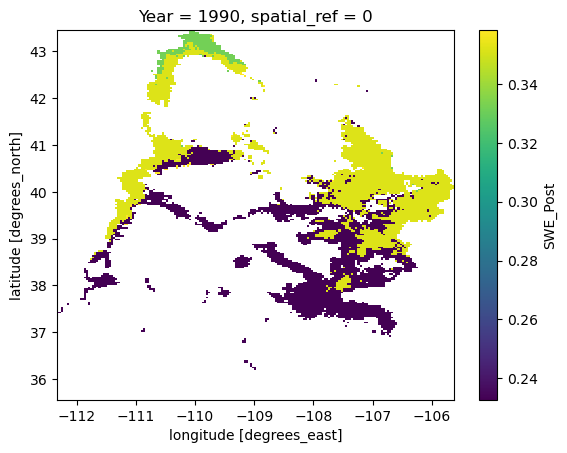

In [118]:
mean_quantile[0].plot()

In [109]:
sr_quantiles_er_2018 = xr.open_dataarray('../data/quantile_ncs/sr_quantiles_2018_er.nc')
sr_quantiles_er_2019 = xr.open_dataarray('../data/quantile_ncs/sr_quantiles_2019_er.nc')
sr_quantiles_er_2020 = xr.open_dataarray('../data/quantile_ncs/sr_quantiles_2020_er.nc')
sr_quantiles_er_2021 = xr.open_dataarray('../data/quantile_ncs/sr_quantiles_2021_er.nc')
sr_quantiles_er_2017 = xr.open_dataarray('../data/quantile_ncs/sr_quantiles_2017_er.nc')

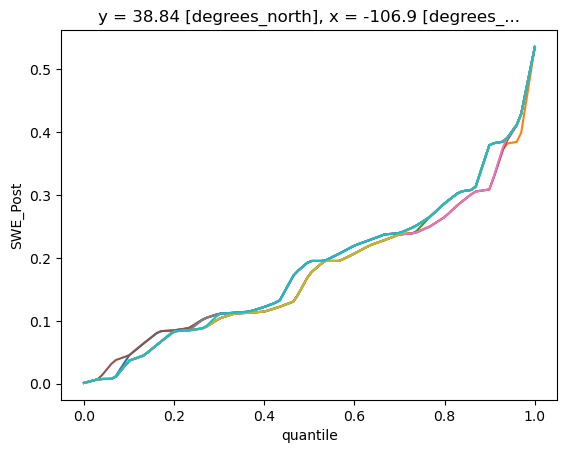

In [111]:
fig, ax = plt.subplots()
sr_quantiles_er_1990.isel(x=40, y=40).plot()
sr_quantiles_er_1991.isel(x=40, y=40).plot()
sr_quantiles_er_1992.isel(x=40, y=40).plot()
sr_quantiles_er_1993.isel(x=40, y=40).plot()
sr_quantiles_er_1994.isel(x=40, y=40).plot()
sr_quantiles_er_2018.isel(x=40, y=40).plot()
sr_quantiles_er_2019.isel(x=40, y=40).plot()
sr_quantiles_er_2020.isel(x=40, y=40).plot()
sr_quantiles_er_2021.isel(x=40, y=40).plot()
sr_quantiles_er_2017.isel(x=40, y=40).plot()

In [85]:
swe_er.SWE_Post.where((swe_er.SWE_Post['Year'] != 1990), drop=True)

<xarray.DataArray 'SWE_Post' (Year: 31, y: 84, x: 84)> Size: 875kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 672B 38.66 38.67 38.67 38.68 ... 39.02 39.03 39.03
  * x            (x) float64 672B -107.1 -107.1 -107.1 ... -106.8 -106.8 -106.7
  * Year         (Year) int64 248B 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 8B 0
Attributes:
    Units:    meters

In [74]:
quantiles = np.linspace(0,1,100)
year = 0
sr_quantiles_er = swe_er.SWE_Post.quantile(quantiles, dim='Year', method='linear')

In [93]:
sr_quantiles_er_interpswe_yr = sr_quantiles_er_yr.interp(quantile=mean_quantile_er, method='linear')

In [94]:
sr_quantiles_er_interpswe_yr.isel(x=40, y=40, Year=0)

<xarray.DataArray 'SWE_Post' ()> Size: 8B
array(0.11377984)
Coordinates:
    quantile     float32 4B 0.3515
    x            float64 8B -106.9
    y            float64 8B 38.84
    Year         int64 8B 1990
    spatial_ref  int64 8B 0

In [95]:
sr_quantiles_er_interpswe.isel(x=40, y=40, Year=0)

<xarray.DataArray 'SWE_Post' ()> Size: 8B
array(0.11265417)
Coordinates:
    quantile     float32 4B 0.3515
    x            float64 8B -106.9
    y            float64 8B 38.84
    Year         int64 8B 1990
    spatial_ref  int64 8B 0

In [91]:
(sr_quantiles_er.isel(x=40, y=40) - sr_quantiles_er_yr.isel(x=40, y=40)).sum()

<xarray.DataArray 'SWE_Post' ()> Size: 4B
array(0., dtype=float32)
Coordinates:
    y        float64 8B 38.84
    x        float64 8B -106.9

In [98]:
mean_quantile_er.isel(x=40, y=40, Year=0)

<xarray.DataArray 'SWE_Post' ()> Size: 4B
array(0.35147843, dtype=float32)
Coordinates:
    y            float64 8B 38.84
    x            float64 8B -106.9
    Year         int64 8B 1990
    spatial_ref  int64 8B 0
Attributes:
    Units:    meters

In [77]:
sr_quantiles_er_interpswe = sr_quantiles_er.interp(quantile=mean_quantile_er, method='linear')

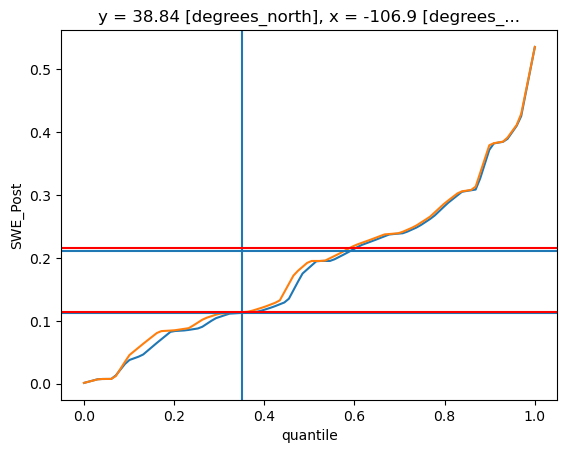

In [101]:
plt.subplots()
sr_quantiles_er.isel(x=40, y=40).plot()
sr_quantiles_er_yr.isel(x=40, y=40).plot()
plt.axvline(x=mean_quantile_er.isel(x=40, y=40, Year=0))
plt.axhline(y=sr_quantiles_er_interpswe.isel(x=40, y=40, Year=0))
plt.axhline(y=sr_quantiles_er_interpswe_yr.isel(x=40, y=40, Year=0), color='red')

plt.axhline(y=sr_quantiles_er_interpswe.isel(x=40, y=40, Year=10))
plt.axhline(y=sr_quantiles_er_interpswe_yr.isel(x=40, y=40, Year=10), color='red')

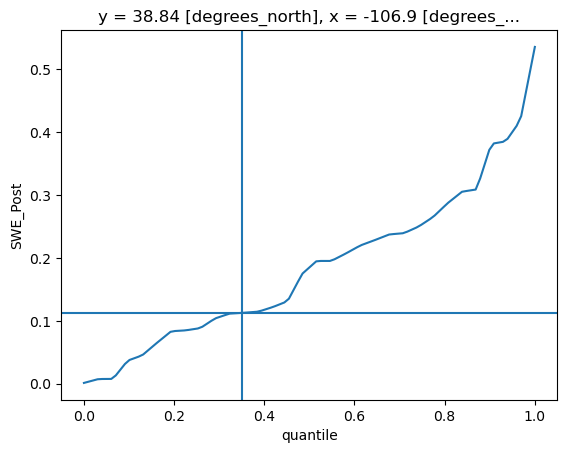

In [68]:
plt.subplots()
sr_quantiles_er.isel(x=40, y=40).plot()
plt.axvline(x=mean_quantile_er.isel(x=40, y=40, Year=0))
plt.axhline(y=sr_quantiles_er_interpswe.isel(x=40, y=40, Year=0))

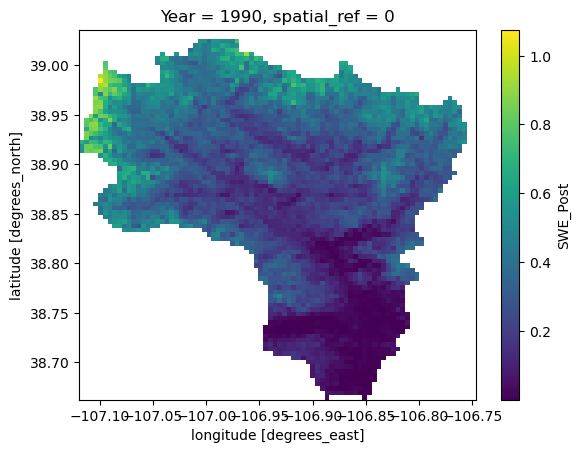

In [60]:
sr_quantiles_er_interpswe[0].plot()

In [ ]:
sr_quantiles.sel(quantile = mean_quantile, method='nearest')

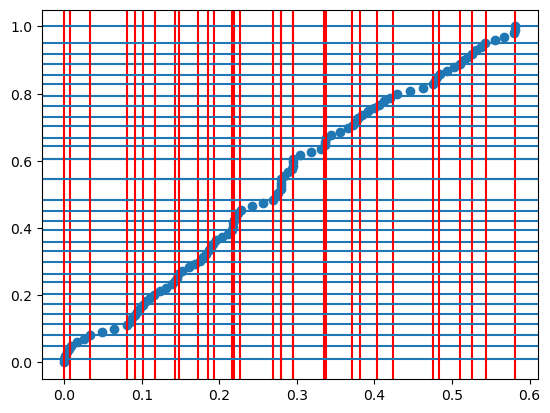

In [33]:
fig, ax = plt.subplots()
plt.scatter(station_ordered, quantiles)
for i in range(len(q_station)):
    plt.axhline(y=q_station[i])
    plt.axvline(x=stations[stations.index.get_level_values(0) == site]['station_swe'].values[i], color='red')

In [69]:
np.nanmin(nearest_station_quantile_sc[0].values)

0.01010101

In [70]:
np.nanmax(nearest_station_quantile_sc[0].values)

0.9192054

In [73]:
np.isinf(nearest_station_quantile_sc[0].values).sum()

0

In [79]:
nearest_station_quantile_sc[0].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [94]:
len(swe.SWE_Post[0].stack(z=("x", "y"))[~np.isnan(swe.SWE_Post[0].stack(z=("x", "y")))].values)

1549763

In [93]:
len(nearest_station_quantile_sc[0].stack(z=("x", "y"))[~np.isnan(nearest_station_quantile_sc[0].stack(z=("x", "y")))].values)

447687

In [98]:
nearest_station_quantile_sc[0].shape

(1776, 1508)

In [97]:
swe.SWE_Post[0].shape

(1776, 1508)

In [92]:
year = 0
to_exclude = [year]
years = [element for k, element in enumerate(np.arange(1990,2022)) if k not in to_exclude]
swe.SWE_Post.stack(z=("x", "y"))[~np.isnan(swe.SWE_Post[0].stack(z=("x", "y")))].quantile(nearest_station_quantile_sc[0].stack(z=("x", "y"))[~np.isnan(nearest_station_quantile_sc[0].stack(z=("x", "y")))],  method = 'median_unbiased', skipna=True).unstack()
#swe_reanalysis_quantile.loc[dict(Year=(year+1990))] = swe.SWE_Post.sel(Year=years).quantile(nearest_station_quantile_sc[0], dim='Year', method = 'median_unbiased')

<xarray.DataArray 'SWE_Post' (quantile: 447687)> Size: 4MB
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * quantile  (quantile) float64 4MB 0.2346 0.2346 0.2346 ... 0.5458 0.5458

What if I do it by category (cluster or station) for each year, so that for each subset I'm only asking it compute a single quantile

In [99]:
swe_reanalysis_quantile = xr.full_like(swe.SWE_Post, np.nan)

In [107]:
site_ids = list(np.unique(nearest_station_sc_4326.data))
site_ids_nan = site_ids[0:-1]

for i in site_ids_nan:
    for year in range(0,32):
        swe_reanalysis_quantile[year] = swe_reanalysis_quantile[year].where(nearest_station_sc_4326 != i, lambda x: swe.SWE_Post.quantile(stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['quantile'].values[0], method = 'linear'))

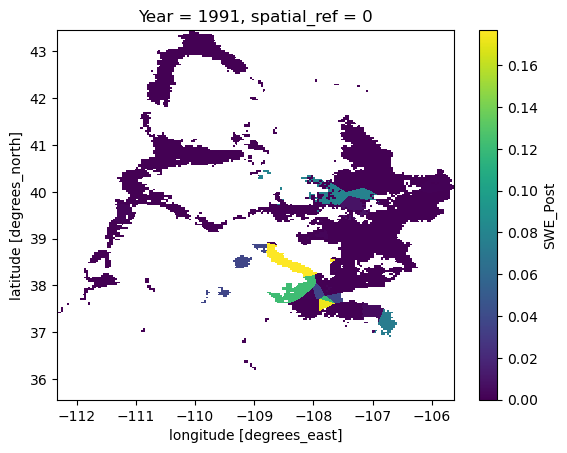

In [106]:
swe_reanalysis_quantile[1].plot()

In [101]:
i = 0
stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['quantile'].values[0]

0.11195928753180662

In [ ]:
site_ids = list(np.unique(nearest_station_4326.data))
site_ids_nan = site_ids[0:-1]

for i in site_ids_nan:
    for year in range(0,32):
        nearest_snv[year] = nearest_snv[year].where((nearest_station_4326 != i), stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['station_n'].values[0])

In [329]:
quantiles = np.linspace(0,1,100)

for year in np.arange(0,32):
    
    # exclude the current year to not 'cheat'
    to_exclude = [year]
    years = [element for k, element in enumerate(np.arange(1990,2022)) if k not in to_exclude]
    
    stations_ordered = stats.mstats.mquantiles(nearest_station_swe_sc_huc10.sel(Year=years).stack(z=("x", "y")).values, quantiles, axis=0)
    reanalysis_ordered = stats.mstats.mquantiles(swe_huc10.SWE_Post.sel(Year=years).stack(z=("x", "y")).values, quantiles, axis=0)

    # Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
    q_station = np.interp(nearest_station_swe_sc_huc10.sel(Year=(year+1990)), stations_ordered, quantiles)
    # Create our interpolation function for looking up SWE at Blue Canyon given a quantile
    #g_reanalysis = np.interp(quantiles, reanalysis_ordered)
    
    # Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
    reanalysis_predicted = np.interp(q_station, quantiles, reanalysis_ordered)
    
    # populate the empty dataset at the selected grid cell:
    # swe_reanalysis_quantile_predictions.loc[dict(x=i, y=j)] = reanalysis_predicted
    
    #     swe_reanalysis_quantile_predictions.SWE_Post.isel(x=i, y=j, Year=year).values = reanalysis_predicted[year]
    swe_reanalysis_quantile_predictions.SWE_Post.loc[dict(Year=(year+1990))] = reanalysis_predicted

TypeError: Array should be 2D at most !

In [338]:
year

0

In [345]:
year
to_exclude = [year]
years = [element for k, element in enumerate(np.arange(1990,2022)) if k not in to_exclude]

stations_ordered = stats.mstats.mquantiles(nearest_station_swe_sc_huc10.sel(Year=years).stack(z=("x", "y")).values, quantiles, axis=0)

In [350]:
reanalysis_ordered = stats.mstats.mquantiles(swe_huc10.SWE_Post.sel(Year=years).stack(z=("x", "y")).values, quantiles, axis=0)

In [365]:
q_station = np.interp(nearest_station_swe_sc_huc10.sel(Year=(year+1990)).stack(z=("x", "y")).values, stations_ordered, quantiles)

ValueError: object too deep for desired array

In [361]:
f_stations = interp1d(stations_ordered, quantiles, axis=0)

IndexError: index 3206 is out of bounds for axis 0 with size 100

In [362]:
stations_ordered.shape

(100, 7056)

In [364]:
quantiles.squeeze().shape

(100,)

In [357]:

        # Create our interpolation function for looking up SWE at Blue Canyon given a quantile
g_reanalysis = interp1d(quantiles, reanalysis_ordered, axis=0)

# Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
reanalysis_predicted = g_reanalysis(f_stations(nearest_station_swe_sc_huc10.sel(Year=(year+1990)).stack(z=("x", "y")).values))

IndexError: index 3206 is out of bounds for axis 0 with size 100

In [354]:
q_station = interp1d(nearest_station_swe_sc_huc10.sel(Year=(year+1990)).stack(z=("x", "y")).values, stations_ordered, quantiles, axis=0)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [351]:
reanalysis_ordered.shape

(100, 7056)

In [347]:
stations_ordered.shape

(100, 7056)

In [341]:
nearest_station_swe_sc_huc10.sel(Year=years).stack(z=("x", "y")).values.shape

(31, 7056)

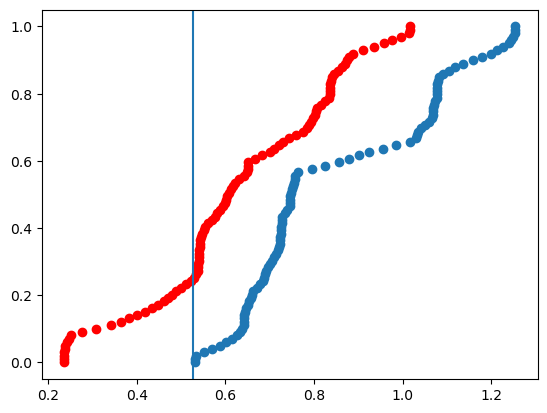

In [314]:
fig, ax = plt.subplots()

plt.scatter(stations_ordered, quantiles)
plt.scatter(reanalysis_ordered,quantiles, color='red')
plt.axvline(x=0.5257)

In [312]:
swe.SWE_Post.sel(x=i,y=j).values

array([0.5242, 0.7978, 0.8362, 1.0164, 0.8064, 0.8688, 0.8406, 0.8346,
       0.9568, 0.5544, 0.5384, 0.6192, 0.2362, 0.652 , 0.354 , 0.7338,
       0.6492, 0.5396, 0.7026, 0.6062, 0.5766, 0.5962, 0.2184, 0.4596,
       0.8812, 0.488 , 0.412 , 0.5414, 0.2368, 0.7824, 0.5444, 0.2528],
      dtype=float32)

In [307]:
stations_ordered

array([0.53086001, 0.53086001, 0.53263031, 0.55104146, 0.56945261,
       0.58786377, 0.60110255, 0.61391031, 0.62671807, 0.63292183,
       0.63692426, 0.64092669, 0.64262003, 0.64262003, 0.64262003,
       0.64391311, 0.64711504, 0.65031697, 0.65351891, 0.65672086,
       0.6599228 , 0.66335566, 0.67056002, 0.67776438, 0.68496874,
       0.68792437, 0.69032582, 0.69272727, 0.69626788, 0.70027031,
       0.70427274, 0.7087062 , 0.71350911, 0.71831203, 0.72165251,
       0.72245299, 0.72325348, 0.72405396, 0.72485444, 0.72565492,
       0.72645541, 0.72725589, 0.72805637, 0.72885685, 0.73372134,
       0.73932474, 0.74492813, 0.74676001, 0.74676001, 0.74676001,
       0.74796073, 0.75036218, 0.75276363, 0.75490338, 0.75650434,
       0.75810531, 0.76413973, 0.79455816, 0.82497658, 0.85539501,
       0.87874762, 0.90196169, 0.92517575, 0.95485527, 0.98607418,
       1.01729309, 1.03022399, 1.03262544, 1.03502688, 1.04075343,
       1.05035926, 1.05996508, 1.06703091, 1.06783139, 1.06863

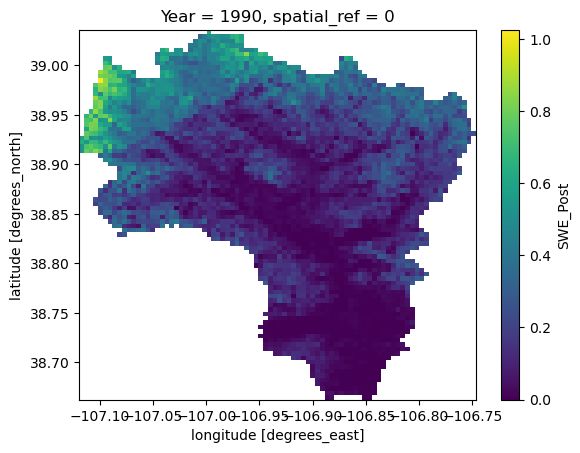

In [265]:
swe_reanalysis_quantile_predictions.SWE_Post[0].plot()

In [332]:
swe_huc10.SWE_Post.shape

(32, 84, 84)

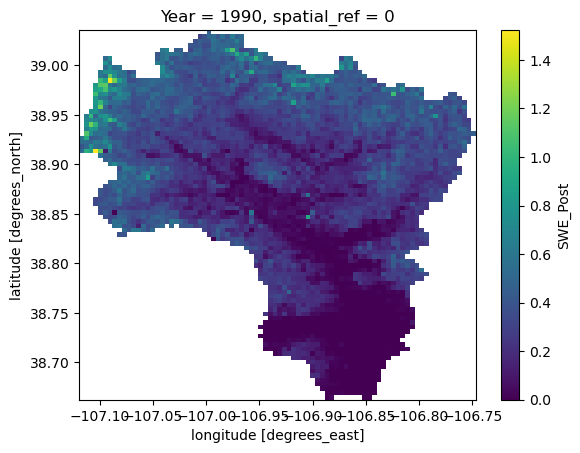

In [266]:
swe_huc10.SWE_Post[0].plot()

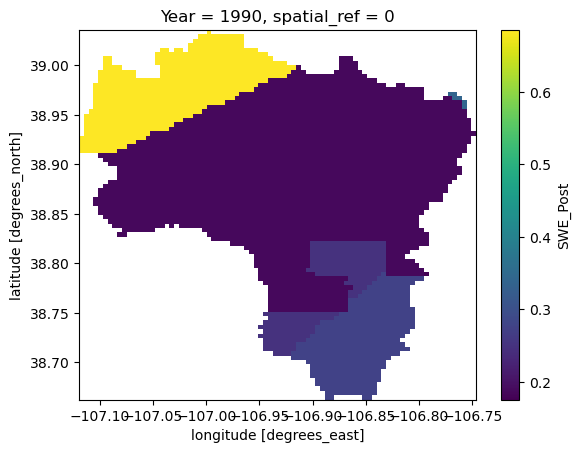

In [268]:
nearest_station_swe_sc_huc10[0].plot()

In [251]:
i = 0
j = 0
x = swe_
swe_reanalysis_quantile_predictions.loc[dict(x=i, y=j)]

AttributeError: 'Dataset' object has no attribute 'iloc'

In [244]:
swe_reanalysis_quantile_predictions

<xarray.Dataset> Size: 905kB
Dimensions:      (Year: 32, y: 84, x: 84)
Coordinates:
  * y            (y) float64 672B 38.66 38.67 38.67 38.68 ... 39.02 39.03 39.03
  * x            (x) float64 672B -107.1 -107.1 -107.1 ... -106.8 -106.8 -106.7
  * Year         (Year) int64 256B 1990 1991 1992 1993 ... 2018 2019 2020 2021
    spatial_ref  int64 8B 0
Data variables:
    SWE_Post     (Year, y, x) float32 903kB nan nan nan nan ... nan nan nan nan

In [213]:
quantiles = np.linspace(0,1,100)

# This is our empirical cdf of the Slide Canyon data, which also includes values down to 0 and up to 1.
stations_ordered = nearest_station_swe_sc_huc10.apply_ufunc(stats.mstats.mquantiles(),nearest_station_swe_sc_huc10.values, quantiles)

# This is our empirical cdf of the Blue Canyon data, which also includes values down to 0 and up to 1.
reanalysis_ordered = stats.mstats.mquantiles(swe_huc10.values, quantiles)

TypeError: Array should be 2D at most !

In [172]:
# Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
f_stations = interp1d(stations_ordered, quantiles)
# Create our interpolation function for looking up SWE at Blue Canyon given a quantile
g_reanalysis = interp1d(quantiles, reanalysis_ordered)

# Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
reanalysis_predicted = g_reanalysis( f_stations(nearest_station_swe_sc.isel(x=idx[0], y=idy[0])) )


In [173]:
reanalysis_predicted

array([0.25237816, 0.40303493, 0.3425007 , 0.69019997, 0.36162511,
       0.59613898, 0.62059594, 0.58553092, 0.39745142, 0.2957325 ,
       0.40692075, 0.3070957 , 0.29163279, 0.4579008 , 0.33328391,
       0.57185185, 0.46202491, 0.31976404, 0.67051094, 0.48772505,
       0.38668004, 0.53271482, 0.1408    , 0.28250221, 0.46810808,
       0.31976404, 0.4399414 , 0.62059594, 0.28250221, 0.58553092,
       0.45990249, 0.31976404])

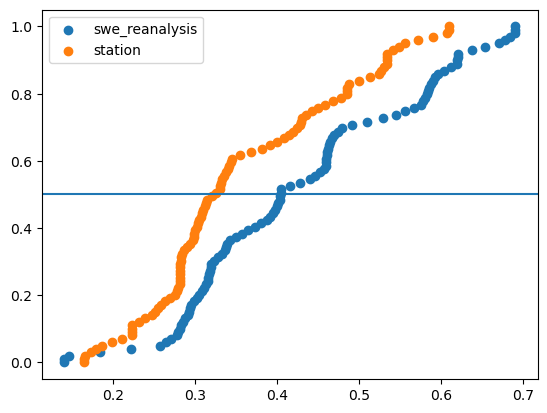

In [174]:
fig, ax = plt.subplots()
plt.scatter(reanalysis_ordered, quantiles, label='swe_reanalysis')
plt.scatter(stations_ordered, quantiles, label='station')
plt.axhline(y=0.5)
plt.legend()

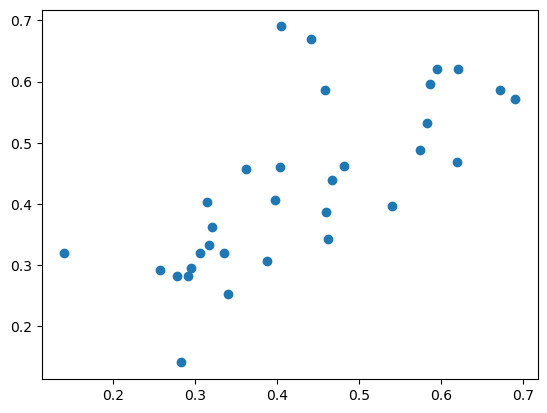

In [175]:
plt.scatter(swe.SWE_Post.isel(x=idx[0], y=idy[0]).values, reanalysis_predicted)

In [131]:
swe.SWE_Post.isel(x=598, y=1712).values

array([1.81  , 2.0352, 2.1148, 1.2452, 1.5628, 1.7678, 2.6656, 2.612 ,
       3.0714, 3.8288, 3.035 , 1.8424, 1.8206, 2.184 , 1.8218, 2.5552,
       3.192 , 2.6204, 2.3626, 2.4838, 3.4684, 3.1068, 3.7142, 2.286 ,
       3.1072, 3.4928, 3.6354, 3.495 , 3.2738, 3.4272, 3.1882, 2.7756],
      dtype=float32)

In [129]:
reanalysis_predicted

array([1.82361818, 2.37153361, 2.02665193, 3.11439673, 2.17821222,
       3.20021855, 3.49733398, 3.71610931, 3.10293824, 3.4094143 ,
       2.66635623, 2.55162525, 2.11396618, 3.18418331, 2.48067679,
       2.77400825, 3.48599757, 1.82017112, 2.60626144, 3.10293824,
       1.24520004, 3.48599757, 3.27920663, 1.70153737, 3.63567874,
       1.8539772 , 1.70153737, 3.82879996, 2.62093422, 3.10293824,
       2.28600878, 1.80981051])

In [110]:
station_quantiles.isel(x=598, y=1712)

<xarray.DataArray 'SWE_Post' (quantile: 15)> Size: 60B
array([0.19304   , 0.23114   , 0.24057429, 0.24910142, 0.25508857,
       0.27268714, 0.2801257 , 0.30861   , 0.32112858, 0.32530144,
       0.34834287, 0.35541856, 0.36830002, 0.45593   , 0.47498   ],
      dtype=float32)
Coordinates:
    y         float64 8B 43.17
    x         float64 8B -109.7
  * quantile  (quantile) float64 120B 0.0 0.07143 0.1429 ... 0.8571 0.9286 1.0

In [95]:
quantiles = np.linspace(0, 1, 15)

In [111]:
quantiles

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])

In [97]:
from scipy.interpolate import interp1d

In [98]:
# Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
f_SLI = interp1d(station_quantiles.isel(x=598, y=1712), quantiles)

In [100]:
g_BLC = interp1d(quantiles, swe_quantiles.isel(x=598, y=1712))

In [101]:
BLC_predicted=g_BLC( f_SLI(swe.SWE_Post.isel(x=598, y=1712)) )

In [102]:
BLC_predicted

array([1.80999994, 2.03520012, 2.11479998, 1.24520004, 1.56280005,
       1.76779997, 2.66560006, 2.61199999, 3.07139993, 3.82879996,
       3.03500009, 1.84239995, 1.82060003, 2.18400002, 1.82179999,
       2.5552001 , 3.19199991, 2.62039995, 2.36260009, 2.48379993,
       3.4684    , 3.10680008, 3.71420002, 2.28600001, 3.10719991,
       3.4928    , 3.63540006, 3.49499989, 3.2737999 , 3.42720008,
       3.1882    , 2.77559996])

In [103]:
swe.SWE_Post.isel(x=598, y=1712)

<xarray.DataArray 'SWE_Post' (Year: 32)> Size: 128B
array([1.81  , 2.0352, 2.1148, 1.2452, 1.5628, 1.7678, 2.6656, 2.612 , 3.0714,
       3.8288, 3.035 , 1.8424, 1.8206, 2.184 , 1.8218, 2.5552, 3.192 , 2.6204,
       2.3626, 2.4838, 3.4684, 3.1068, 3.7142, 2.286 , 3.1072, 3.4928, 3.6354,
       3.495 , 3.2738, 3.4272, 3.1882, 2.7756], dtype=float32)
Coordinates:
    y            float64 8B 43.17
    x            float64 8B -109.7
  * Year         (Year) int64 256B 1990 1991 1992 1993 ... 2018 2019 2020 2021
    spatial_ref  int64 8B ...
Attributes:
    Units:    meters

In [ ]:
# Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
f_SLI = interp1d(SLI_ordered, quantiles)
# Create our interpolation function for looking up SWE at Blue Canyon given a quantile
g_BLC = interp1d(quantiles, BLC_ordered)

# Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
BLC_predicted=g_BLC( f_SLI( data['SLI_max'] ) )


In [ ]:
gridcell_swe = swe.SWE_Post.sel(Year=0, x=)

In [ ]:
station_quantiles = np.percentile(nearest_station_swe_sc.values, )

In [80]:
swe_quantiles.sel(quantile=0.071429).plot()

KeyError: "not all values found in index 'quantile'. Try setting the `method` keyword argument (example: method='nearest')."

In [78]:
np.linspace(0, 1, 15)

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])

In [75]:
swe_quantiles = swe_flat.quantile(q=np.linspace(0, 1, 15), dim='Year', method = 'weibull')

KeyboardInterrupt: 

In [74]:
nearest_station_quantiles = nearest_station_flat.quantile(q=np.linspace(0, 1, 15), dim='Year', method='weibull')

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


KeyboardInterrupt: 

In [ ]:
def quantile_mapping(model_data, model_quantiles, observed_quantiles):
    rank = np.argsort(model_data, axis=0)
    model_data_sorted = np.sort(model_data, axis=0)
    mapped_data = np.interp(np.linspace(0, 1, len(model_data)), 
                            model_quantiles, observed_quantiles)
    mapped_data_sorted = mapped_data[rank]
    return mapped_data_sorted